1. Demographic data (traindemographics.csv)(df1)
- customerid (Primary key used to merge to other data)
- birthdate (date of birth of the customer)
- bank_account_type (type of primary bank account)
- longitude_gps
- latitude_gps
- bank_name_clients (name of the bank)
- bank_branch_clients (location of the branch - not compulsory - so missing in a lot of the cases)
- employment_status_clients (type of employment that customer has)
- level_of_education_clients (highest level of education)
2. Performance data (trainperf.csv) (df2): This is the repeat loan that the customer has taken for which we need to predict the performance of. Basically, we need to predict whether this loan would default given all previous loans and demographics of a customer.
- customerid (Primary key used to merge to other data)
- systemloanid (The id associated with the particular loan. The same customerId can have multiple systemloanid’s for each loan he/she has taken out)
- loannumber (The number of the loan that you have to predict)
- approveddate (Date that loan was approved)
- creationdate (Date that loan application was created)
- loanamount (Loan value taken)
- totaldue (Total repayment required to settle the loan - this is the capital loan value disbursed +interest and fees)
- termdays (Term of loan)
- referredby (customerId of the customer that referred this person - is missing, then not referred)
- good_bad_flag (good = settled loan on time; bad = did not settled loan on time) - this is the target variable that we need to predict
3. Previous loans data (trainprevloans.csv)(df3) : This dataset contains all previous loans that the customer had prior to the loan above that we want to predict the performance of. Each loan will have a different systemloanid, but the same customerid for each customer.
- customerid (Primary key used to merge to other data)
- systemloanid (The id associated with the particular loan. The same customerId can have multiple systemloanid’s for each loan he/she has taken out)
- loannumber (The number of the loan that you have to predict)
- approveddate (Date that loan was approved)
- creationdate (Date that loan application was created)
- loanamount (Date that loan application was created)
- totaldue (Total repayment required to settle the loan - this is the capital- loan value disbursed +interest and fees) termdays (Term of loan)
- closeddate (Date that the loan was settled)
- referredby (customerId of the customer that referred this person - is missing, then not refrerred)
- firstduedate (Date of first payment due in cases where the term is longer than 30 days. So in the case where the term is 60+ days - then there are multiple monthly payments due - and this dates reflects the date of the first payment)
- firstrepaiddate (Actual date that he/she paid the first payment as defined above)

In [ ]:
# import all necessary libraries
!pip install xgboost --quiet
!pip install catboost --quiet
!pip install shap --quiet
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings. filterwarnings ('ignore')
from datetime import datetime
import time
import shap
pd.set_option('display.max_rows', None)
pd.set_option ('display.float_format','{:.2f}'.format)

from sklearn.model_selection import train_test_split
import plotly.express as px
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import VarianceThreshold # feature selector
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.metrics import (
accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 9.5 MB/s eta 0:00:00


DEMOGRAPHIC DATA (traindemographic.csv)

In [ ]:
url = 'https://raw.githubusercontent.com/Oyeniran20/axia_cohort_8/refs/heads/main/traindemographics.csv'
df1 = pd.read_csv(url)
df1.head()

,customerid,birthdate,bank_account_type,longitude_gps,latitude_gps,bank_name_clients,bank_branch_clients,employment_status_clients,level_of_education_clients
0,8a858e135cb22031015cbafc76964ebd,1973-10-10 00:00:00.000000,Savings,3.32,6.53,GT Bank,NaN,NaN,NaN
1,8a858e275c7ea5ec015c82482d7c3996,1986-01-21 00:00:00.000000,Savings,3.33,7.12,Sterling Bank,NaN,Permanent,NaN
2,8a858e5b5bd99460015bdc95cd485634,1987-04-01 00:00:00.000000,Savings,5.75,5.56,Fidelity Bank,NaN,NaN,NaN
3,8a858efd5ca70688015cabd1f1e94b55,1991-07-19 00:00:00.000000,Savings,3.36,6.64,GT Bank,NaN,Permanent,NaN
4,8a858e785acd3412015acd48f4920d04,1982-11-22 00:00:00.000000,Savings,8.46,11.97,GT Bank,NaN,Permanent,NaN



Cleaning and Validating the data on the dataset

In [ ]:

print(df1.shape) # Check shape (rows, columns)
df1.info() # Check data types and non-null counts
df1.describe() # Summary statistics for numerical columns

(4346, 9)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4346 entries, 0 to 4345
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   customerid                  4346 non-null   object 
 1   birthdate                   4346 non-null   object 
 2   bank_account_type           4346 non-null   object 
 3   longitude_gps               4346 non-null   float64
 4   latitude_gps                4346 non-null   float64
 5   bank_name_clients           4346 non-null   object 
 6   bank_branch_clients         51 non-null     object 
 7   employment_status_clients   3698 non-null   object 
 8   level_of_education_clients  587 non-null    object 
dtypes: float64(2), object(7)
memory usage: 305.7+ KB


,longitude_gps,latitude_gps
count,4346.00,4346.00
mean,4.63,7.25
std,7.18,3.06
min,-118.25,-33.87
25%,3.35,6.47
50%,3.59,6.62
75%,6.55,7.43
max,151.21,71.23


- There are 4346 rows and 9 colums in these dataset

In [ ]:
# check for duplicated value
df1.duplicated().sum()

df1['customerid'].duplicated().sum()

np.int64(12)

- There are 12 duplicated values in the dataset

In [ ]:
#drop duplicate
df1.drop_duplicates(inplace=True)

In [ ]:
df1.duplicated().sum()

np.int64(0)

In [ ]:
# Show the count of missing values per column
print(df1.isnull().sum())

# just see if there's any missing data at all
print(df1.isnull().values.any())

customerid                       0
birthdate                        0
bank_account_type                0
longitude_gps                    0
latitude_gps                     0
bank_name_clients                0
bank_branch_clients           4283
employment_status_clients      648
level_of_education_clients    3748
dtype: int64
True


- There are missing values in the dataset.

In [ ]:
# filling the missing values

# Fill 'employment_status_clients' with the most common value
df1['employment_status_clients'] = df1['employment_status_clients'].fillna(
    df1['employment_status_clients'].mode()[0]
)

In [ ]:
# For columns with high missingness (>80%), we consider dropping
df1.drop(['bank_branch_clients', 'level_of_education_clients'], axis=1, inplace=True)

In [ ]:
#check again for missing value
df1.isnull().sum()

,0
customerid,0
birthdate,0
bank_account_type,0
longitude_gps,0
latitude_gps,0
bank_name_clients,0
employment_status_clients,0


In [ ]:
# To Calculate age and create a new column for age to know the customer age
df1['birthdate'] = pd.to_datetime(df1['birthdate'])
current_year = pd.to_datetime('now').year
df1['age'] = current_year - df1['birthdate'].dt.year

In [ ]:
# Check for impossible ages
df1 = df1[df1['age'].between(18, 100)]  # Reasonable age range for borrowers

In [ ]:
print("Latitude range:", df1['latitude_gps'].min(), "to", df1['latitude_gps'].max())
print("Longitude range:", df1['longitude_gps'].min(), "to", df1['longitude_gps'].max())

Latitude range: -33.8688183 to 71.2280693936817
Longitude range: -118.2470093 to 151.20929


In [ ]:
df1.head()

,customerid,birthdate,bank_account_type,longitude_gps,latitude_gps,bank_name_clients,employment_status_clients,age
0,8a858e135cb22031015cbafc76964ebd,1973-10-10,Savings,3.32,6.53,GT Bank,Permanent,52
1,8a858e275c7ea5ec015c82482d7c3996,1986-01-21,Savings,3.33,7.12,Sterling Bank,Permanent,39
2,8a858e5b5bd99460015bdc95cd485634,1987-04-01,Savings,5.75,5.56,Fidelity Bank,Permanent,38
3,8a858efd5ca70688015cabd1f1e94b55,1991-07-19,Savings,3.36,6.64,GT Bank,Permanent,34
4,8a858e785acd3412015acd48f4920d04,1982-11-22,Savings,8.46,11.97,GT Bank,Permanent,43


In [ ]:
print(df1.isnull().sum())

customerid                   0
birthdate                    0
bank_account_type            0
longitude_gps                0
latitude_gps                 0
bank_name_clients            0
employment_status_clients    0
age                          0
dtype: int64


PERFORMANCE DATA (trainperf.csv)

In [ ]:
url = 'https://raw.githubusercontent.com/Oyeniran20/axia_cohort_8/refs/heads/main/trainperf.csv'
df2 = pd.read_csv(url)
df2.head()

,customerid,systemloanid,loannumber,approveddate,creationdate,loanamount,totaldue,termdays,referredby,good_bad_flag
0,8a2a81a74ce8c05d014cfb32a0da1049,301994762,12,2017-07-25 08:22:56.000000,2017-07-25 07:22:47.000000,30000.00,34500.00,30,NaN,Good
1,8a85886e54beabf90154c0a29ae757c0,301965204,2,2017-07-05 17:04:41.000000,2017-07-05 16:04:18.000000,15000.00,17250.00,30,NaN,Good
2,8a8588f35438fe12015444567666018e,301966580,7,2017-07-06 14:52:57.000000,2017-07-06 13:52:51.000000,20000.00,22250.00,15,NaN,Good
3,8a85890754145ace015429211b513e16,301999343,3,2017-07-27 19:00:41.000000,2017-07-27 18:00:35.000000,10000.00,11500.00,15,NaN,Good
4,8a858970548359cc0154883481981866,301962360,9,2017-07-03 23:42:45.000000,2017-07-03 22:42:39.000000,40000.00,44000.00,30,NaN,Good


**Cleaning and Validating the data**

In [ ]:
print(df2.shape) # Check shape (rows, columns)
df2.info() # Check data types and non-null counts
df2.describe() # Summary statistics for numerical columns

(4368, 10)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4368 entries, 0 to 4367
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   customerid     4368 non-null   object 
 1   systemloanid   4368 non-null   int64  
 2   loannumber     4368 non-null   int64  
 3   approveddate   4368 non-null   object 
 4   creationdate   4368 non-null   object 
 5   loanamount     4368 non-null   float64
 6   totaldue       4368 non-null   float64
 7   termdays       4368 non-null   int64  
 8   referredby     587 non-null    object 
 9   good_bad_flag  4368 non-null   object 
dtypes: float64(2), int64(3), object(5)
memory usage: 341.4+ KB


,systemloanid,loannumber,loanamount,totaldue,termdays
count,4368.00,4368.00,4368.00,4368.00,4368.00
mean,301980956.66,5.17,17809.07,21257.38,29.26
std,13431.15,3.65,10749.69,11943.51,11.51
min,301958485.00,2.00,10000.00,10000.00,15.00
25%,301969128.00,2.00,10000.00,13000.00,30.00
50%,301980100.00,4.00,10000.00,13000.00,30.00
75%,301993503.50,7.00,20000.00,24500.00,30.00
max,302004050.00,27.00,60000.00,68100.00,90.00


- there are 4368 rows and 10 columns in these dataset

In [ ]:
# view the columns
df2.columns

Index(['customerid', 'systemloanid', 'loannumber', 'approveddate',
       'creationdate', 'loanamount', 'totaldue', 'termdays', 'referredby',
       'good_bad_flag'],
      dtype='object')

In [ ]:
# check for duplicated value
df2.duplicated().sum()

np.int64(0)

- There are no missing values.

In [ ]:
# Show the count of missing values per column
print(df2.isnull().sum())

# just see if there's any missing data at all
print(df2.isnull().values.any())

customerid          0
systemloanid        0
loannumber          0
approveddate        0
creationdate        0
loanamount          0
totaldue            0
termdays            0
referredby       3781
good_bad_flag       0
dtype: int64
True


- There are missing values in refferedby.

In [ ]:
# Handle missing referredby (too many missing to be useful)
df2.drop('referredby', axis=1, inplace=True)

In [ ]:
# checking for the uniqueness of loanamount
df2.loanamount.unique()

array([30000., 15000., 20000., 10000., 40000., 25000., 50000., 35000.,
       45000., 60000.])

In [ ]:
# checking for the uniqueness of totaldue
df2.totaldue.unique()

array([34500. , 17250. , 22250. , 11500. , 44000. , 39000. , 13000. ,
       28750. , 24500. , 48000. , 11125. , 16687.5, 52500. , 21750. ,
       12250. , 18375. , 11000. , 57500. , 15750. , 33000. , 21500. ,
       55000. , 10750. , 23000. , 12500. , 27500. , 38500. , 10000. ,
       49500. , 22000. , 21000. , 24000. , 10500. , 36000. , 42000. ,
       16125. , 10250. , 38500.2, 68100. , 62700. , 16500. , 43500. ,
       65400. , 33999.9, 20500. , 57000.5, 31500. ])

In [ ]:
# checking for the uniqueness of termdays
df2.termdays.unique()

array([30, 15, 60, 90])

In [ ]:
# Convert date columns to datetime
df2['approveddate'] = pd.to_datetime(df2['approveddate'])
df2['creationdate'] = pd.to_datetime(df2['creationdate'])

In [ ]:
# Verify loan amounts are positive
assert (df2['loanamount'] > 0).all()

In [ ]:
# Check termdays validity
assert (df2['termdays'].between(1, 365)).all()  # Assuming max 1-year term

In [ ]:
# Verify totaldue >= loanamount
assert (df2['totaldue'] >= df2['loanamount']).all()

In [ ]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4368 entries, 0 to 4367
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   customerid     4368 non-null   object        
 1   systemloanid   4368 non-null   int64         
 2   loannumber     4368 non-null   int64         
 3   approveddate   4368 non-null   datetime64[ns]
 4   creationdate   4368 non-null   datetime64[ns]
 5   loanamount     4368 non-null   float64       
 6   totaldue       4368 non-null   float64       
 7   termdays       4368 non-null   int64         
 8   good_bad_flag  4368 non-null   object        
dtypes: datetime64[ns](2), float64(2), int64(3), object(2)
memory usage: 307.3+ KB


In [ ]:
# Merge the performance and demographic datasets
df_main = pd.merge(df1, df2, on='customerid', how='inner')

In [ ]:
# checking for the shame
df_main.shape

(3269, 16)

- After merging df1 and df2, it has 3269 rows and 16 columns.

In [ ]:
# checking the info
df_main.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3269 entries, 0 to 3268
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   customerid                 3269 non-null   object        
 1   birthdate                  3269 non-null   datetime64[ns]
 2   bank_account_type          3269 non-null   object        
 3   longitude_gps              3269 non-null   float64       
 4   latitude_gps               3269 non-null   float64       
 5   bank_name_clients          3269 non-null   object        
 6   employment_status_clients  3269 non-null   object        
 7   age                        3269 non-null   int32         
 8   systemloanid               3269 non-null   int64         
 9   loannumber                 3269 non-null   int64         
 10  approveddate               3269 non-null   datetime64[ns]
 11  creationdate               3269 non-null   datetime64[ns]
 12  loanam

PREVIOUS LOAN (trainprevloans.csv)

In [ ]:
url = 'https://raw.githubusercontent.com/Oyeniran20/axia_cohort_8/refs/heads/main/trainprevloans.csv'
df3 = pd.read_csv(url)
df3.head()

,customerid,systemloanid,loannumber,approveddate,creationdate,loanamount,totaldue,termdays,closeddate,referredby,firstduedate,firstrepaiddate
0,8a2a81a74ce8c05d014cfb32a0da1049,301682320,2,2016-08-15 18:22:40.000000,2016-08-15 17:22:32.000000,10000.00,13000.00,30,2016-09-01 16:06:48.000000,NaN,2016-09-14 00:00:00.000000,2016-09-01 15:51:43.000000
1,8a2a81a74ce8c05d014cfb32a0da1049,301883808,9,2017-04-28 18:39:07.000000,2017-04-28 17:38:53.000000,10000.00,13000.00,30,2017-05-28 14:44:49.000000,NaN,2017-05-30 00:00:00.000000,2017-05-26 00:00:00.000000
2,8a2a81a74ce8c05d014cfb32a0da1049,301831714,8,2017-03-05 10:56:25.000000,2017-03-05 09:56:19.000000,20000.00,23800.00,30,2017-04-26 22:18:56.000000,NaN,2017-04-04 00:00:00.000000,2017-04-26 22:03:47.000000
3,8a8588f35438fe12015444567666018e,301861541,5,2017-04-09 18:25:55.000000,2017-04-09 17:25:42.000000,10000.00,11500.00,15,2017-04-24 01:35:52.000000,NaN,2017-04-24 00:00:00.000000,2017-04-24 00:48:43.000000
4,8a85890754145ace015429211b513e16,301941754,2,2017-06-17 09:29:57.000000,2017-06-17 08:29:50.000000,10000.00,11500.00,15,2017-07-14 21:18:43.000000,NaN,2017-07-03 00:00:00.000000,2017-07-14 21:08:35.000000


**Cleaning and Validating the data**

In [ ]:
print(df3.shape) # Check shape (rows, columns)
df3.info() # Check data types and non-null counts
df3.describe() # Summary statistics for numerical columns

(18183, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18183 entries, 0 to 18182
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   customerid       18183 non-null  object 
 1   systemloanid     18183 non-null  int64  
 2   loannumber       18183 non-null  int64  
 3   approveddate     18183 non-null  object 
 4   creationdate     18183 non-null  object 
 5   loanamount       18183 non-null  float64
 6   totaldue         18183 non-null  float64
 7   termdays         18183 non-null  int64  
 8   closeddate       18183 non-null  object 
 9   referredby       1026 non-null   object 
 10  firstduedate     18183 non-null  object 
 11  firstrepaiddate  18183 non-null  object 
dtypes: float64(2), int64(3), object(7)
memory usage: 1.7+ MB


,systemloanid,loannumber,loanamount,totaldue,termdays
count,18183.00,18183.00,18183.00,18183.00,18183.00
mean,301839474.01,4.19,16501.24,19573.20,26.69
std,93677.67,3.25,9320.55,10454.25,10.95
min,301600134.00,1.00,3000.00,3450.00,15.00
25%,301776577.00,2.00,10000.00,11500.00,15.00
50%,301854965.00,3.00,10000.00,13000.00,30.00
75%,301919682.50,6.00,20000.00,24500.00,30.00
max,302000275.00,26.00,60000.00,68100.00,90.00


In [ ]:
# check for duplicated values
df3.duplicated().sum()

np.int64(0)

In [ ]:
# check for missing values in customer id
df3['customerid'].duplicated().sum()

np.int64(13824)

- There are 13824 duplicated values in customer id.

In [ ]:
# Show the count of missing values per column
print(df3.isnull().sum())

# just see if there's any missing data at all
print(df3.isnull().values.any())

customerid             0
systemloanid           0
loannumber             0
approveddate           0
creationdate           0
loanamount             0
totaldue               0
termdays               0
closeddate             0
referredby         17157
firstduedate           0
firstrepaiddate        0
dtype: int64
True


- There are missing values in reffered by.

In [ ]:
(df3.isna().sum().sort_values(ascending=False)/len(df3))*100

,0
referredby,94.36
customerid,0.00
loannumber,0.00
systemloanid,0.00
approveddate,0.00
creationdate,0.00
totaldue,0.00
loanamount,0.00
termdays,0.00
closeddate,0.00


In [ ]:
# Handling Missing Value For referredby - drop if mostly missing
df3.drop('referredby', axis=1, inplace=True)

In [ ]:
# Convert all date columns
date_cols = ['approveddate', 'creationdate', 'closeddate', 'firstduedate', 'firstrepaiddate']
for col in date_cols:
    df3[col] = pd.to_datetime(df3[col])

In [ ]:
# checking for duplicates
df3.duplicated() .sum()

np.int64(0)

In [ ]:
# checking for duplicates in the primary key
df3['customerid']. duplicated(). sum()

np.int64(13824)

In [ ]:
# checking for number of unique customers
df3['customerid']. nunique()

4359

- Financial data to build a predictive model, enhancing accuracy and efficiency in risk assessment as this will cause a data misalignment it not treated. In other not to contradict the aim of this project I then need to find a way to make sure that the customerid unique, i.e., making it one customer to one loan one row one customer). By doing this we are able to utilize the customers behavior and financial data effectively to predict our model and gain proper or efficient risk assessment.
To be able to make our customerid unique in our customers previous loan dataset, We need to Aggregate df3 to one row per column of loans and total loan amount so as to enable us merge with both the customers performance dataset and the customers demographics data misalignment and also deviating from our aim.


**Aggregation and Feature Engineering of the Customers Previous Loan Dataset**

In [ ]:
# i will create some new features with th already existing feature and then aggregate
df3['repayment_ratio'] = df3['totaldue'] / df3['loanamount']
# Loan duration in days (cLosed - approved)
df3['duration_days'] = (df3['closeddate'] - df3['approveddate']).dt.days
# Time to first repayment
df3['repay_delay_days'] = (df3[ 'firstrepaiddate'] - df3['firstduedate']).dt.days
# Flag for first repayment deLay - 1 if payment was late, 0 if on-time/early
df3['firstrepaid late'] = (df3['repay_delay_days'] > 0). astype(int)
# Closure or Settlement deLay
df3[ 'closed_late'] = (df3['duration_days'] > df3['termdays']).astype (int)
df3[ 'interest'] = df3[ 'totaldue'] - df3['loanamount']
# interest rate
df3['interest_rate'] = df3['interest'] / df3['loanamount']

In [ ]:
# checking the dataset
df3.head()

,customerid,systemloanid,loannumber,approveddate,creationdate,loanamount,totaldue,termdays,closeddate,firstduedate,firstrepaiddate,repayment_ratio,duration_days,repay_delay_days,firstrepaid late,closed_late,interest,interest_rate
0,8a2a81a74ce8c05d014cfb32a0da1049,301682320,2,2016-08-15 18:22:40,2016-08-15 17:22:32,10000.00,13000.00,30,2016-09-01 16:06:48,2016-09-14,2016-09-01 15:51:43,1.30,16,-13,0,0,3000.00,0.30
1,8a2a81a74ce8c05d014cfb32a0da1049,301883808,9,2017-04-28 18:39:07,2017-04-28 17:38:53,10000.00,13000.00,30,2017-05-28 14:44:49,2017-05-30,2017-05-26 00:00:00,1.30,29,-4,0,0,3000.00,0.30
2,8a2a81a74ce8c05d014cfb32a0da1049,301831714,8,2017-03-05 10:56:25,2017-03-05 09:56:19,20000.00,23800.00,30,2017-04-26 22:18:56,2017-04-04,2017-04-26 22:03:47,1.19,52,22,1,1,3800.00,0.19
3,8a8588f35438fe12015444567666018e,301861541,5,2017-04-09 18:25:55,2017-04-09 17:25:42,10000.00,11500.00,15,2017-04-24 01:35:52,2017-04-24,2017-04-24 00:48:43,1.15,14,0,0,0,1500.00,0.15
4,8a85890754145ace015429211b513e16,301941754,2,2017-06-17 09:29:57,2017-06-17 08:29:50,10000.00,11500.00,15,2017-07-14 21:18:43,2017-07-03,2017-07-14 21:08:35,1.15,27,11,1,1,1500.00,0.15


In [ ]:
# aggregating the new features on the customerid using groupby
df3_agg = df3. groupby ('customerid').agg({
'systemloanid': 'count', # number of past Loans
'loanamount': ['mean', 'max','min'],
'firstrepaid late': 'sum', # total late first repayments
'closed_late': 'sum', # total late closures
'repayment_ratio': 'mean', # average repayment ratio
'duration_days': 'mean', # average loan duration
'interest_rate': 'mean', # average interest rate
'interest': 'mean'
}).reset_index()

In [ ]:
# renaming the columns of the new dataset
df3_agg.columns = ['customerid', 'num_prev_loans', 'avg_prev_loanamount', 'max_prev_loanamount', 'min_prev_loanamount', 'total_firstrepaid_late', 'total_closed_late', 'avg_prev_repayment_ratio', 'avg_duration_days',
      'avg_prev_interest_rate', 'avg_prev_interest']

In [ ]:
# view th agg columns
df3_agg.head()

,customerid,num_prev_loans,avg_prev_loanamount,max_prev_loanamount,min_prev_loanamount,total_firstrepaid_late,total_closed_late,avg_prev_repayment_ratio,avg_duration_days,avg_prev_interest_rate,avg_prev_interest
0,8a1088a0484472eb01484669e3ce4e0b,1,10000.00,10000.00,10000.00,1,1,1.15,22.00,0.15,1500.00
1,8a1a1e7e4f707f8b014f797718316cad,4,17500.00,30000.00,10000.00,1,1,1.28,31.25,0.28,4875.00
2,8a1a32fc49b632520149c3b8fdf85139,7,12857.14,20000.00,10000.00,1,1,1.17,18.29,0.17,2357.14
3,8a1eb5ba49a682300149c3c068b806c7,8,16250.00,30000.00,10000.00,1,0,1.26,28.50,0.26,4050.00
4,8a1edbf14734127f0147356fdb1b1eb2,2,10000.00,10000.00,10000.00,0,0,1.23,18.00,0.22,2250.00


In [ ]:
#check the size of the dataset
df3_agg.shape

(4359, 11)

In [ ]:
# check if the customer id is unique
df3_agg['customerid'].nunique()

4359

In [ ]:
#check the information of the dataset
df3_agg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4359 entries, 0 to 4358
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   customerid                4359 non-null   object 
 1   num_prev_loans            4359 non-null   int64  
 2   avg_prev_loanamount       4359 non-null   float64
 3   max_prev_loanamount       4359 non-null   float64
 4   min_prev_loanamount       4359 non-null   float64
 5   total_firstrepaid_late    4359 non-null   int64  
 6   total_closed_late         4359 non-null   int64  
 7   avg_prev_repayment_ratio  4359 non-null   float64
 8   avg_duration_days         4359 non-null   float64
 9   avg_prev_interest_rate    4359 non-null   float64
 10  avg_prev_interest         4359 non-null   float64
dtypes: float64(7), int64(3), object(1)
memory usage: 374.7+ KB


In [ ]:
# checking for duplicates
df3_agg.duplicated().sum()

np.int64(0)

After inspecting, cleaning, and organising the dataset in a way that all the customersid in all three datasets are unique, i,e, no duplicate custumerid. This makes our datasets ready to be merged.
On merging, I will now merge Customers performance dataset with the Customers Demographics dataset using the inner join on the customerid, reason being that I want to work with customers that nave complete demograpnic data leaving me with clean and consistent dataser where every customer has not performance and demograpnic information.

In [ ]:
# merge df_main to df3
df_final = pd.merge(df_main, df3_agg, on='customerid', how='left')

In [ ]:
# checking the shape of the merged dataset
df_final.shape

(3269, 26)

In [ ]:
# checking the information of the merged dataset
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3269 entries, 0 to 3268
Data columns (total 26 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   customerid                 3269 non-null   object        
 1   birthdate                  3269 non-null   datetime64[ns]
 2   bank_account_type          3269 non-null   object        
 3   longitude_gps              3269 non-null   float64       
 4   latitude_gps               3269 non-null   float64       
 5   bank_name_clients          3269 non-null   object        
 6   employment_status_clients  3269 non-null   object        
 7   age                        3269 non-null   int32         
 8   systemloanid               3269 non-null   int64         
 9   loannumber                 3269 non-null   int64         
 10  approveddate               3269 non-null   datetime64[ns]
 11  creationdate               3269 non-null   datetime64[ns]
 12  loanam

In [ ]:
# check for missing values
df_final.isna().sum()

,0
customerid,0
birthdate,0
bank_account_type,0
longitude_gps,0
latitude_gps,0
bank_name_clients,0
employment_status_clients,0
age,0
systemloanid,0
loannumber,0


Now to deal with this missing value problem, I will fill with default values such as:
* 0 for counts → model understands "this customer has never done this before."
* 0 or -1 for ratios → lets the model differentiate between "value is actually 0" and "no history."
* "no _history" for categories → model can learn if lack of history is a risk signal.

In [ ]:
# Filling missing values with 0
df_final.fillna({
    'avg_prev_interest_rate': 0,
    'total_firstrepaid_late': 0,
    'total_closed_late':0,
    'avg_prev_repayment_ratio': 0,
    'avg_duration_days': 0,
    'num_prev_loans': 0,
    'max_prev_loanamount': 0,
    'min_prev_loanamount': 0,
    'avg_prev_loanamount':0,
    'avg_prev_interest': 0
}, inplace=True)

In [ ]:
# checking for percentage of missing values
(df_final.isna().sum().sort_values(ascending=False)/len(df_final))*100

,0
customerid,0.00
birthdate,0.00
bank_account_type,0.00
longitude_gps,0.00
latitude_gps,0.00
bank_name_clients,0.00
employment_status_clients,0.00
age,0.00
systemloanid,0.00
loannumber,0.00


- No more missing values.

In [ ]:
# view the dataset
df_final.head()

,customerid,birthdate,bank_account_type,longitude_gps,latitude_gps,bank_name_clients,employment_status_clients,age,systemloanid,loannumber,...,num_prev_loans,avg_prev_loanamount,max_prev_loanamount,min_prev_loanamount,total_firstrepaid_late,total_closed_late,avg_prev_repayment_ratio,avg_duration_days,avg_prev_interest_rate,avg_prev_interest
0,8a858e135cb22031015cbafc76964ebd,1973-10-10,Savings,3.32,6.53,GT Bank,Permanent,52,301964962,2,...,1.00,10000.00,10000.00,10000.00,0.00,0.00,1.15,15.00,0.15,1500.00
1,8a858e275c7ea5ec015c82482d7c3996,1986-01-21,Savings,3.33,7.12,Sterling Bank,Permanent,39,301972172,2,...,1.00,10000.00,10000.00,10000.00,1.00,1.00,1.30,32.00,0.30,3000.00
2,8a858e5b5bd99460015bdc95cd485634,1987-04-01,Savings,5.75,5.56,Fidelity Bank,Permanent,38,301976271,4,...,3.00,10000.00,10000.00,10000.00,2.00,2.00,1.20,20.67,0.20,2000.00
3,8a858efd5ca70688015cabd1f1e94b55,1991-07-19,Savings,3.36,6.64,GT Bank,Permanent,34,301997763,2,...,1.00,10000.00,10000.00,10000.00,1.00,1.00,1.15,33.00,0.15,1500.00
4,8a858ea05a859123015a8892914d15b7,1990-07-21,Savings,3.37,6.56,Access Bank,Permanent,35,301992494,6,...,5.00,14000.00,20000.00,10000.00,0.00,1.00,1.27,27.00,0.27,3600.00


In [ ]:
# size of the dataset
df_final.shape

(3269, 26)

In [ ]:
#check the columns
df_final.columns

Index(['customerid', 'birthdate', 'bank_account_type', 'longitude_gps',
       'latitude_gps', 'bank_name_clients', 'employment_status_clients', 'age',
       'systemloanid', 'loannumber', 'approveddate', 'creationdate',
       'loanamount', 'totaldue', 'termdays', 'good_bad_flag', 'num_prev_loans',
       'avg_prev_loanamount', 'max_prev_loanamount', 'min_prev_loanamount',
       'total_firstrepaid_late', 'total_closed_late',
       'avg_prev_repayment_ratio', 'avg_duration_days',
       'avg_prev_interest_rate', 'avg_prev_interest'],
      dtype='object')

I will utilize the latitude and longitude coordinates in the dataset to determine the geographic locations of all data points. Rather than restricting the analysis of a specific country, I will consider all points irrespective of their geographic boundaries. This approach involves mapping each coordinate globally and extracting the corresponding place names (such as city, state, and country) to enrich the dataset with meaningful location information. This will enhance the spatial analysis and visualization by providing clear, contextual geographic references for all data entries.

In [ ]:
# plotting the gps coordinates on a worldmap
fig = px.scatter_mapbox(
df_final,
lat = "latitude_gps",
lon = "longitude_gps",
center={"lat": df_final['latitude_gps'].mean(), "lon": df_final['longitude_gps'].mean()},
width=800,
height=600,
zoom=6
)
fig.update_layout(mapbox_style="open-street-map")
fig.show()

- Since location has been obtained, i will drop longitude and lattitude columns.

**FEATURE ENGINEERING OF THE df_final MERGED DATASET**

I will move forward to engineering few features from the total merged datasets of the customer's performance, demographic and previous loan dataset using our customers behavior and finanacial data.
First, will engineer the age using the creation date and the birthdate to get the various customers age after which i will then drop the birthdate as it will no longer be useful for our analysis and prediction. Next, I will engineer the age-group of the various customers to distiguish between the young adults, adults, middle-aged adults and old adults to discover the age group that defaults the most and so on.

In [ ]:
# Calculate the age using birthdate
df_final['age'] = (df_final['creationdate'] - df_final['birthdate']).dt.days//365

In [ ]:
# checking for the unique values of the age
df_final.age.unique()

array([43, 31, 30, 26, 27, 24, 22, 47, 23, 28, 29, 34, 32, 33, 40, 37, 41,
       44, 25, 36, 51, 39, 38, 42, 49, 35, 45, 48, 21, 46, 50, 53, 52, 54,
       55])

In [ ]:
# checking the minimum and maximus age of the customers
min_age = df_final['age'].min()
max_age = df_final['age'].max()

print("Minimum age:", min_age)
print("Maximum age:", max_age)

Minimum age: 21
Maximum age: 55


In [ ]:
# dropping the birthdate
df_final.drop('birthdate', axis=1, inplace=True)

In [ ]:
# viewing the dataset
df_final.head()

,customerid,bank_account_type,longitude_gps,latitude_gps,bank_name_clients,employment_status_clients,age,systemloanid,loannumber,approveddate,...,num_prev_loans,avg_prev_loanamount,max_prev_loanamount,min_prev_loanamount,total_firstrepaid_late,total_closed_late,avg_prev_repayment_ratio,avg_duration_days,avg_prev_interest_rate,avg_prev_interest
0,8a858e135cb22031015cbafc76964ebd,Savings,3.32,6.53,GT Bank,Permanent,43,301964962,2,2017-07-05 14:29:48,...,1.00,10000.00,10000.00,10000.00,0.00,0.00,1.15,15.00,0.15,1500.00
1,8a858e275c7ea5ec015c82482d7c3996,Savings,3.33,7.12,Sterling Bank,Permanent,31,301972172,2,2017-07-10 21:21:46,...,1.00,10000.00,10000.00,10000.00,1.00,1.00,1.30,32.00,0.30,3000.00
2,8a858e5b5bd99460015bdc95cd485634,Savings,5.75,5.56,Fidelity Bank,Permanent,30,301976271,4,2017-07-13 15:40:27,...,3.00,10000.00,10000.00,10000.00,2.00,2.00,1.20,20.67,0.20,2000.00
3,8a858efd5ca70688015cabd1f1e94b55,Savings,3.36,6.64,GT Bank,Permanent,26,301997763,2,2017-07-26 21:03:17,...,1.00,10000.00,10000.00,10000.00,1.00,1.00,1.15,33.00,0.15,1500.00
4,8a858ea05a859123015a8892914d15b7,Savings,3.37,6.56,Access Bank,Permanent,27,301992494,6,2017-07-23 21:44:43,...,5.00,14000.00,20000.00,10000.00,0.00,1.00,1.27,27.00,0.27,3600.00


From the Customers Previous Loan, i will create the Customer's Credit Score and The Customer's Payment Behavior Score

In [ ]:
# Avoid division by zero
total_payments = df_final[ 'total_firstrepaid_late'] + df_final['total_closed_late'] + 1
# Approximate on-time payment
on_time_payments = total_payments * df_final[ 'avg_prev_repayment_ratio']
# Calculate on-time ratio
on_time_ratio = on_time_payments / total_payments
# Cap on _time ratio at 1.0 to avoid unrealistic scores
on_time_ratio = on_time_ratio.clip(upper=1.0)
# Final credit score in range 300-850
df_final['credit_score'] = 300 + (on_time_ratio * 550)
# Avoid division by zero
total_payments = df_final['total_firstrepaid_late'] + df_final['total_closed_late'] + 1
# Calculate on-time payments
on_time_payments = total_payments * df_final['avg_prev_repayment_ratio']
# Payment behavior score (0-100)
df_final['payment_behavior_score'] = (on_time_payments / total_payments) * 100

In [ ]:
# view dataset
df_final.head()

,customerid,bank_account_type,longitude_gps,latitude_gps,bank_name_clients,employment_status_clients,age,systemloanid,loannumber,approveddate,...,max_prev_loanamount,min_prev_loanamount,total_firstrepaid_late,total_closed_late,avg_prev_repayment_ratio,avg_duration_days,avg_prev_interest_rate,avg_prev_interest,credit_score,payment_behavior_score
0,8a858e135cb22031015cbafc76964ebd,Savings,3.32,6.53,GT Bank,Permanent,43,301964962,2,2017-07-05 14:29:48,...,10000.00,10000.00,0.00,0.00,1.15,15.00,0.15,1500.00,850.00,115.00
1,8a858e275c7ea5ec015c82482d7c3996,Savings,3.33,7.12,Sterling Bank,Permanent,31,301972172,2,2017-07-10 21:21:46,...,10000.00,10000.00,1.00,1.00,1.30,32.00,0.30,3000.00,850.00,130.00
2,8a858e5b5bd99460015bdc95cd485634,Savings,5.75,5.56,Fidelity Bank,Permanent,30,301976271,4,2017-07-13 15:40:27,...,10000.00,10000.00,2.00,2.00,1.20,20.67,0.20,2000.00,850.00,120.00
3,8a858efd5ca70688015cabd1f1e94b55,Savings,3.36,6.64,GT Bank,Permanent,26,301997763,2,2017-07-26 21:03:17,...,10000.00,10000.00,1.00,1.00,1.15,33.00,0.15,1500.00,850.00,115.00
4,8a858ea05a859123015a8892914d15b7,Savings,3.37,6.56,Access Bank,Permanent,27,301992494,6,2017-07-23 21:44:43,...,20000.00,10000.00,0.00,1.00,1.27,27.00,0.27,3600.00,850.00,127.00


VISUALIZATION OF OUR DATASET

After veryfying that our datset is clean, we move now to visualizing each column in our dataset for analysis. To do this I will split them into numerical, categorical and datetime as we have from our available columns.
lam going to drop some features as I believe that they will not de useful for our predicton.
Below is a summary of the columns we removed from our dataset before training the predictive model, along with the reasons for their removal:

customerid: This is a unique Identner for each customer. It does not have any relationsnip with loan repayment denavior ana provides no predictive signal.

systemLoanid: This is a unique identifier for each loan transaction. Like customerid, it is purely administrative and carries no predictive value.

approveddate: While dates can be useful when transformed into features like "month" or "day of week," the raw approval date itself is too granular and will not generalize well in predictions. Instead, derived features are preferred.

creationdate: Same reasoning as approveddate — raw dare values have imted predicive value but derived tempora nattems may be useful.

longitude_gps: Raw GPS coordinates are too detailed to be directly useful.

latitude_gps: Raw GPS coordinates are too detailed to be directly useful.

Loannumber: Sequential loan count per customer dropped to prevent data leakage and redundancy with num prev loans.

bank_name_client: It acts as an identifier and usually doesnt provide predictive information for loan default risk.


In [ ]:
# drop the colums
df_final.drop(['customerid', 'systemloanid', 'approveddate', 'creationdate', 'longitude_gps', 'latitude_gps', 'loannumber', 'bank_name_clients'], axis=1, inplace=True)

In [ ]:
# view info
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3269 entries, 0 to 3268
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   bank_account_type          3269 non-null   object 
 1   employment_status_clients  3269 non-null   object 
 2   age                        3269 non-null   int64  
 3   loanamount                 3269 non-null   float64
 4   totaldue                   3269 non-null   float64
 5   termdays                   3269 non-null   int64  
 6   good_bad_flag              3269 non-null   object 
 7   num_prev_loans             3269 non-null   float64
 8   avg_prev_loanamount        3269 non-null   float64
 9   max_prev_loanamount        3269 non-null   float64
 10  min_prev_loanamount        3269 non-null   float64
 11  total_firstrepaid_late     3269 non-null   float64
 12  total_closed_late          3269 non-null   float64
 13  avg_prev_repayment_ratio   3269 non-null   float

**Exploratory Data Analysis (EDA)**

In [ ]:
# Separate columns by data type
cat_cols = df_final.select_dtypes(include=['object', 'category']).columns.tolist()
num_cols = df_final.select_dtypes(include=['number']).columns.tolist()
cat_cols = [col for col in cat_cols if col not in 'good_bad_flag']

In [ ]:
# num columns
num_cols

['age',
 'loanamount',
 'totaldue',
 'termdays',
 'num_prev_loans',
 'avg_prev_loanamount',
 'max_prev_loanamount',
 'min_prev_loanamount',
 'total_firstrepaid_late',
 'total_closed_late',
 'avg_prev_repayment_ratio',
 'avg_duration_days',
 'avg_prev_interest_rate',
 'avg_prev_interest',
 'credit_score',
 'payment_behavior_score']

In [ ]:
# cat columns
cat_cols

['bank_account_type', 'employment_status_clients']

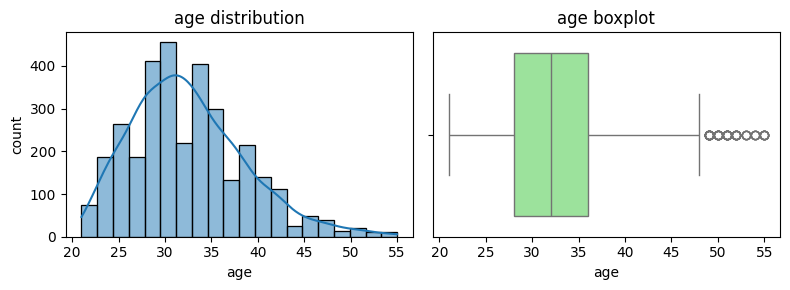

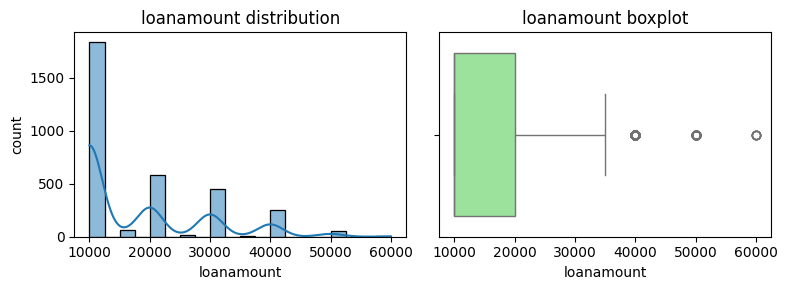

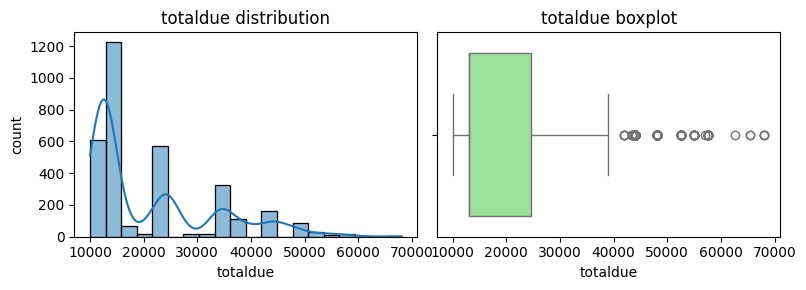

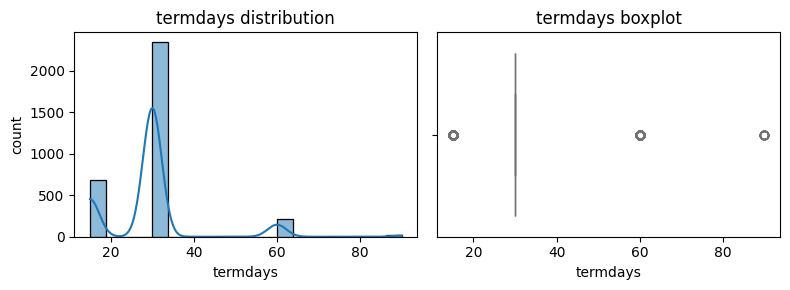

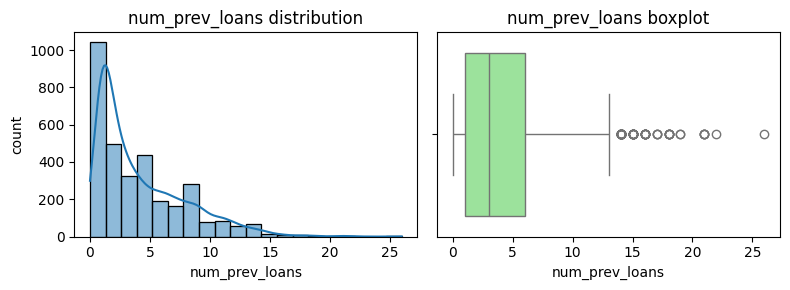

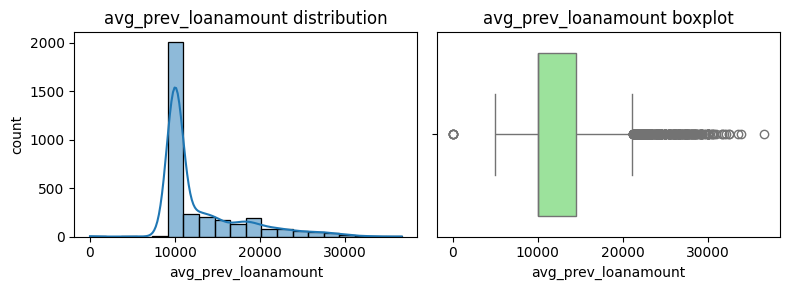

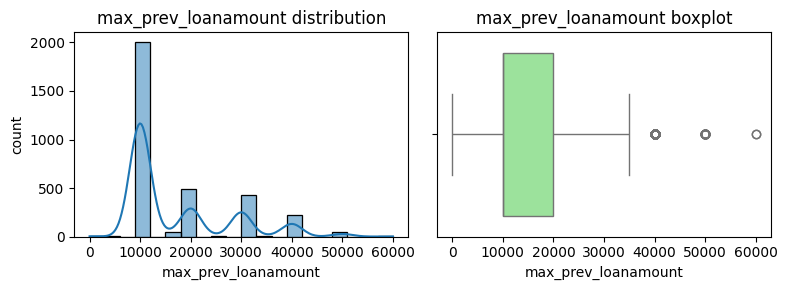

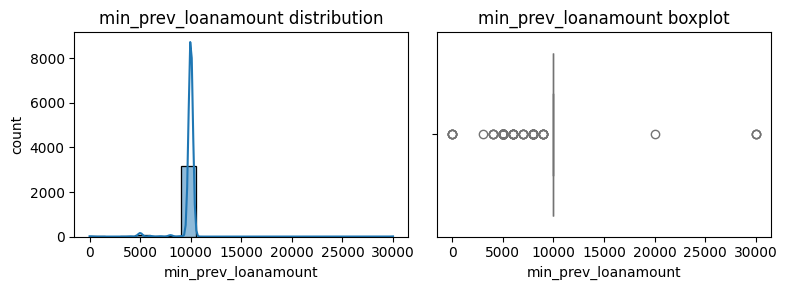

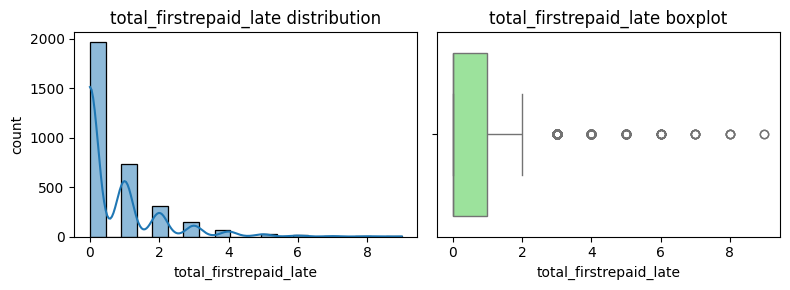

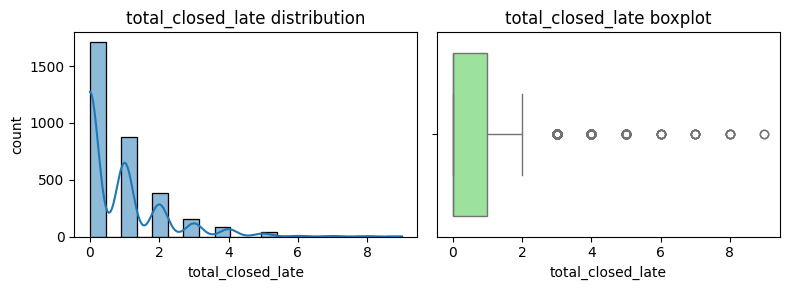

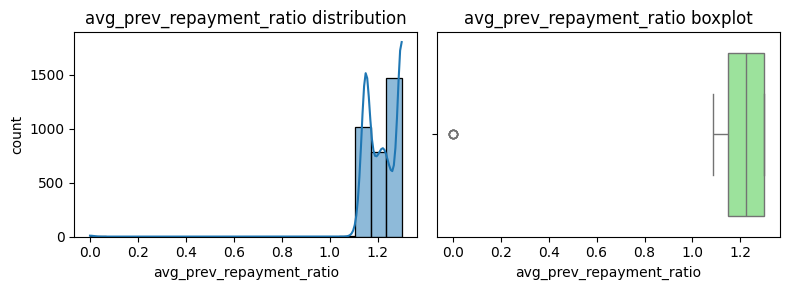

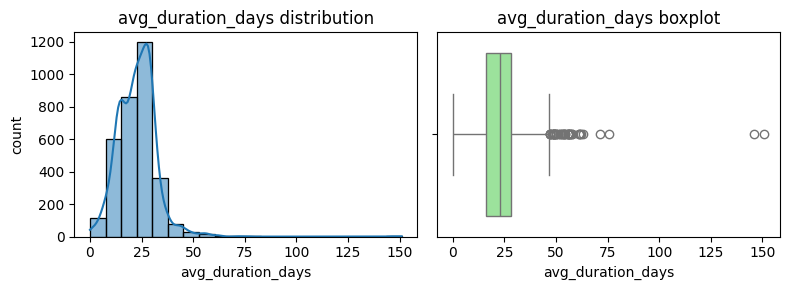

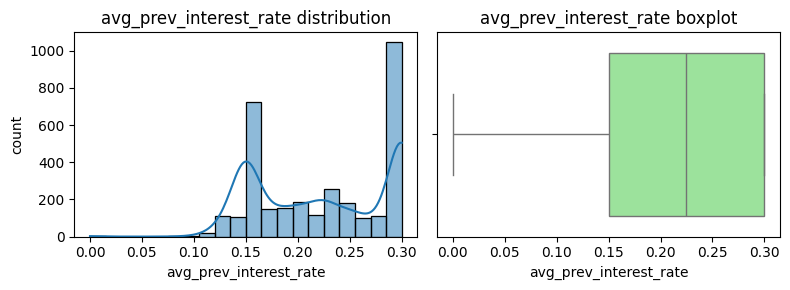

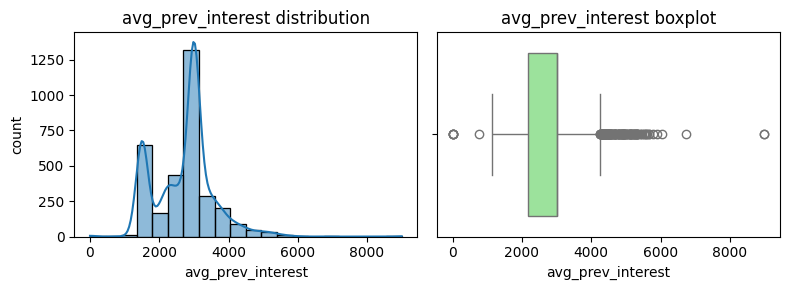

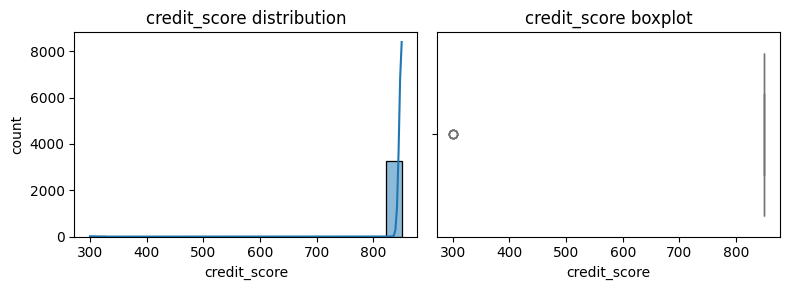

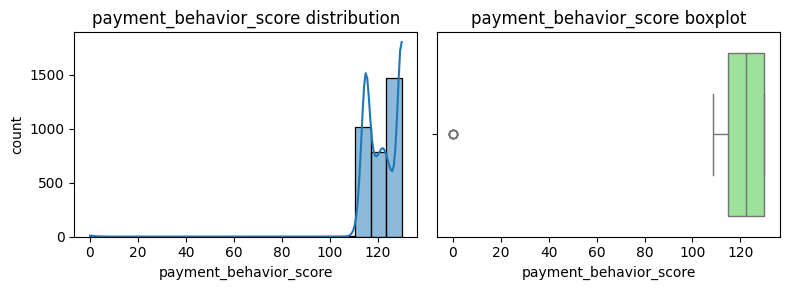

In [ ]:
# Loop through numerical columns
for col in num_cols:
  plt.figure(figsize=(8, 3))
  # plot histogram
  plt.subplot(1, 2, 1)
  sns.histplot(df_final[col], bins=20, kde=True)
  plt.title(f'{col} distribution')
  plt.xlabel(col)
  plt.ylabel('count')

  # plot boxplot
  plt.subplot(1, 2, 2)
  sns.boxplot(x = df_final[col], color='lightgreen')
  plt.title(f'{col} boxplot')
  plt.xlabel(col)

  plt.tight_layout()
  plt.show()

The numerical columns showed skewness in their distribution with variables in loan amount boxplot, firstrepaid late boxplot, total closed late boxplot, previous repayment ratio boxplot, average duration days boxplot, average previous interest boxplot,credit score boxplot, and payment behaviour score boxplot.

In [ ]:
# descriptive statistics
df_final[num_cols].describe()

,age,loanamount,totaldue,termdays,num_prev_loans,avg_prev_loanamount,max_prev_loanamount,min_prev_loanamount,total_firstrepaid_late,total_closed_late,avg_prev_repayment_ratio,avg_duration_days,avg_prev_interest_rate,avg_prev_interest,credit_score,payment_behavior_score
count,3269.00,3269.00,3269.00,3269.00,3269.00,3269.00,3269.00,3269.00,3269.00,3269.00,3269.00,3269.00,3269.00,3269.00,3269.00,3269.00
mean,32.48,17837.26,21287.07,29.25,4.18,12926.64,16953.20,9876.41,0.72,0.85,1.22,22.81,0.22,2731.82,849.16,122.26
std,6.16,10742.90,11929.00,11.40,3.67,4875.97,10389.50,1060.02,1.18,1.22,0.08,9.40,0.06,855.77,21.50,7.95
min,21.00,10000.00,10000.00,15.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,300.00,0.00
25%,28.00,10000.00,13000.00,30.00,1.00,10000.00,10000.00,10000.00,0.00,0.00,1.15,16.17,0.15,2166.67,850.00,115.00
50%,32.00,10000.00,13000.00,30.00,3.00,10000.00,10000.00,10000.00,0.00,0.00,1.23,23.00,0.22,3000.00,850.00,122.50
75%,36.00,20000.00,24500.00,30.00,6.00,14444.44,20000.00,10000.00,1.00,1.00,1.30,28.44,0.30,3000.00,850.00,130.00
max,55.00,60000.00,68100.00,90.00,26.00,36666.67,60000.00,30000.00,9.00,9.00,1.30,151.00,0.30,9000.00,850.00,130.00


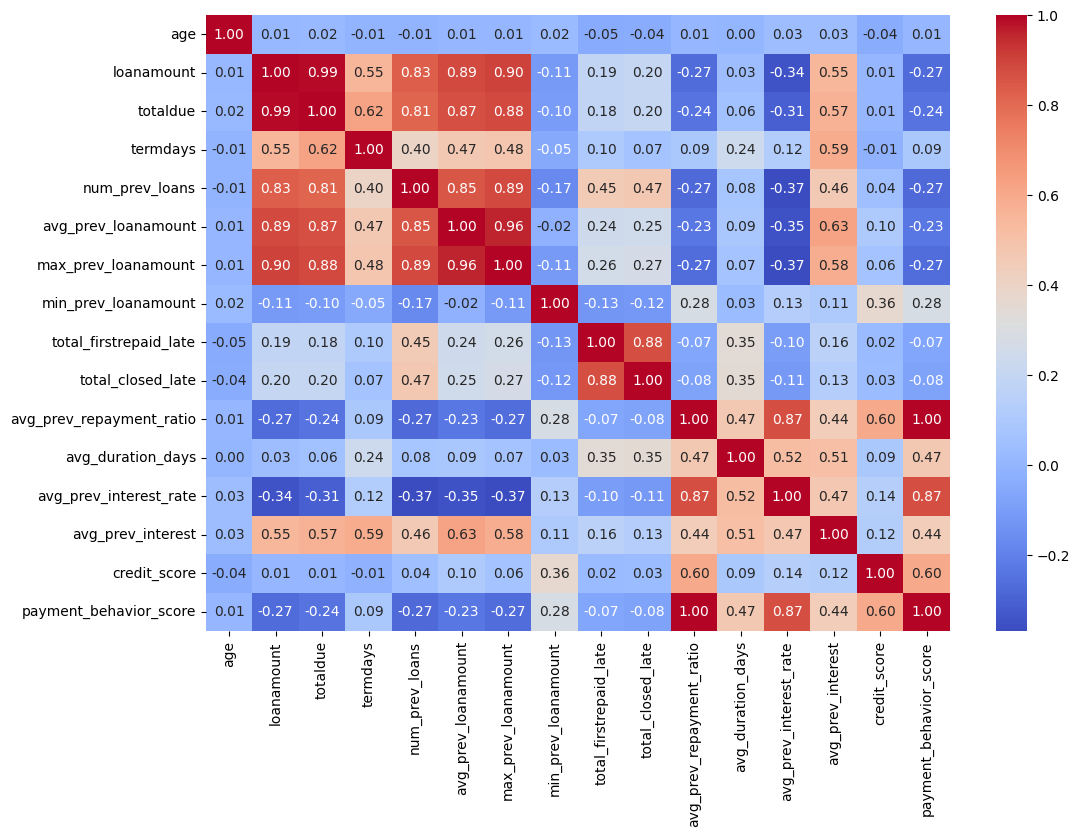

In [ ]:
corr_matrix = df_final[num_cols].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt ='.2f', cmap='coolwarm')
plt.show()

There is a strong positive correlation (0.99) between totaldue and loan amount, indicating near-duplicate information. This high multicollinearity could cause redundancy and instability in predictive models and should be addressed by dropping or combining one of these features.

A moderate positive correlation (0.62) exists between term_days and totaldue, suggesting some overlap in the information these features provide.


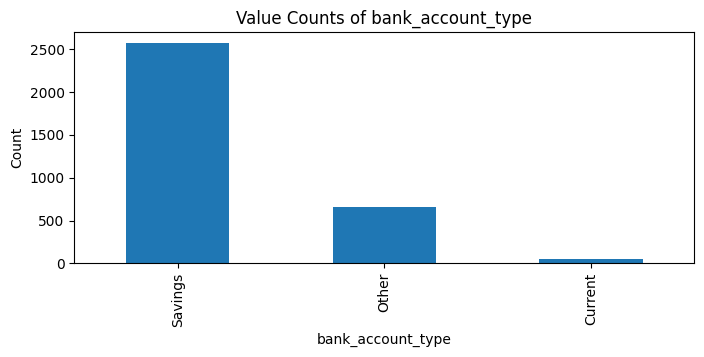

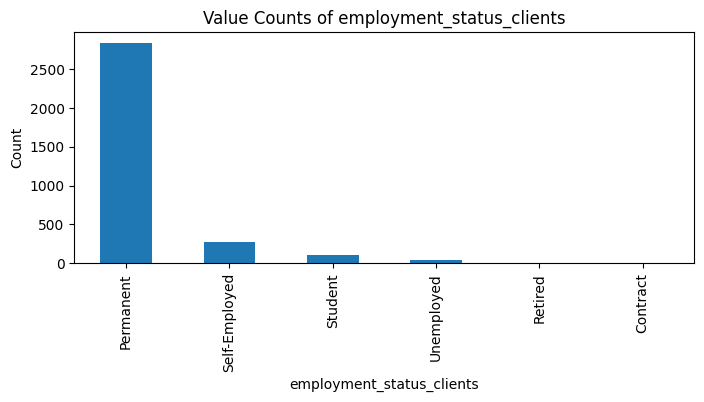

In [ ]:
# Loop through categorical columns and plot value counts
for col in cat_cols:
    plt.figure(figsize=(8, 3))
    df_final[col].value_counts().plot(kind='bar')
    plt.title(f'Value Counts of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.show()

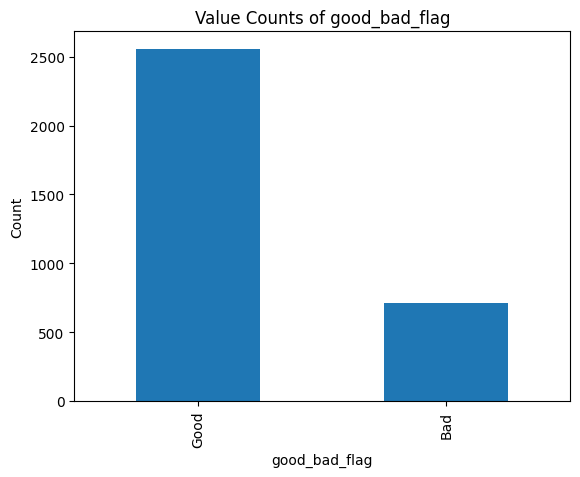

In [ ]:
# target column
df_final['good_bad_flag'].value_counts().plot(kind='bar')
plt.title('Value Counts of good_bad_flag')
plt.xlabel('good_bad_flag')
plt.ylabel('Count')
plt.show()

In [ ]:
# unique value uf the target column
df_final.good_bad_flag.unique()

array(['Good', 'Bad'], dtype=object)

In [ ]:
# convert text to number
df_final.good_bad_flag = (df_final.good_bad_flag == 'Good'). astype(int)

In [ ]:
# unique value of the target column
df_final.good_bad_flag.unique()

array([1, 0])

<Axes: xlabel='good_bad_flag'>

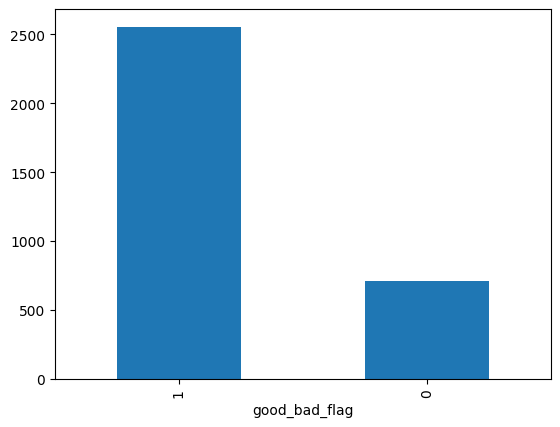

In [ ]:
df_final.good_bad_flag.value_counts().plot(kind='bar')

In [ ]:
# seperate the features and target
X = df_final.drop(columns='good_bad_flag')
y = df_final['good_bad_flag']

In [ ]:
# seperate into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

* The dataset has been split into training and to evaluate performance on unseen data.
* Stratifying by the target preserves class balance in both sets, important for imbalanced data.
* The fixed random state ensures reproducibility.

Data preprocessing

In [ ]:
# split into cat and num cols
cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
num_cols = X.select_dtypes(include=['number']).columns.tolist()

In [ ]:
num_cols

['age',
 'loanamount',
 'totaldue',
 'termdays',
 'num_prev_loans',
 'avg_prev_loanamount',
 'max_prev_loanamount',
 'min_prev_loanamount',
 'total_firstrepaid_late',
 'total_closed_late',
 'avg_prev_repayment_ratio',
 'avg_duration_days',
 'avg_prev_interest_rate',
 'avg_prev_interest',
 'credit_score',
 'payment_behavior_score']

In [ ]:
cat_cols

['bank_account_type', 'employment_status_clients']

In [ ]:
# column transformer pipeline
# num tranformer
num_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])
# cat transformer
cat_transformer = Pipeline(steps=[
    ('encoder', OneHotEncoder(sparse_output=False, handle_unknown='ignore').fit(df_final[cat_cols]))
])

In [ ]:
# column transformer pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('scaled_num', num_transformer, num_cols),
        ('encoded_cat', cat_transformer, cat_cols),
    ])

In [ ]:
preprocessor

ColumnTransformer(transformers=[('scaled_num',
                                 Pipeline(steps=[('scaler', StandardScaler())]),
                                 ['age', 'loanamount', 'totaldue', 'termdays',
                                  'num_prev_loans', 'avg_prev_loanamount',
                                  'max_prev_loanamount', 'min_prev_loanamount',
                                  'total_firstrepaid_late', 'total_closed_late',
                                  'avg_prev_repayment_ratio',
                                  'avg_duration_days', 'avg_prev_interest_rate',
                                  'avg_prev_interest', 'credit_score',
                                  'payment_behavior_score']),
                                ('encoded_cat',
                                 Pipeline(steps=[('encoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['bank_account_type',
                                  'employment_status_clients'])])

In [ ]:
 # define our model
models = {"Logistic Regression": LogisticRegression(),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "XGBoost": XGBClassifier(random_state=42),
    "CatBoost": CatBoostClassifier(random_seed=42, verbose=0),
    "LightGBM": LGBMClassifier(random_state=42, verbose=0),
    "Ada Boost": AdaBoostClassifier(random_state=42)
}

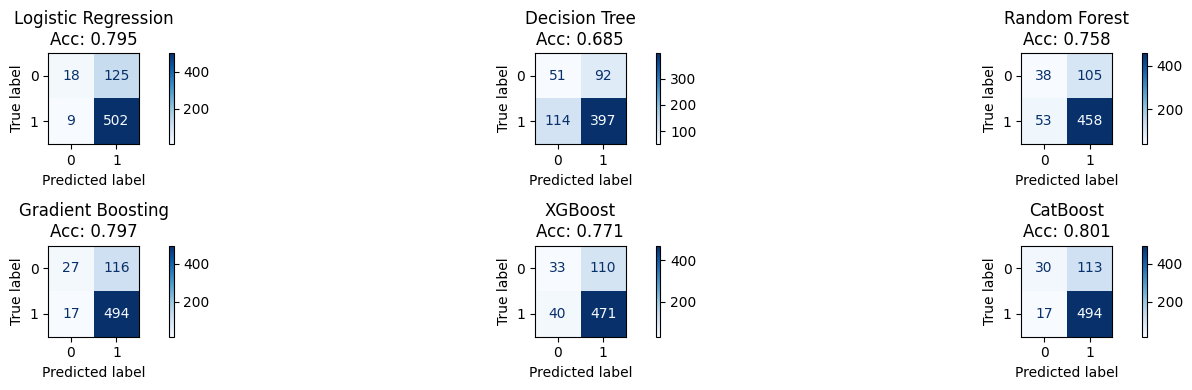

Model Performance:
                     train_acc  test_acc  precision  recall   f1  roc_auc
Logistic Regression       0.79      0.80       0.80    0.98 0.88     0.72
Decision Tree             0.98      0.69       0.81    0.78 0.79     0.57
Random Forest             0.98      0.76       0.81    0.90 0.85     0.67
Gradient Boosting         0.82      0.80       0.81    0.97 0.88     0.71
XGBoost                   0.92      0.77       0.81    0.92 0.86     0.67
CatBoost                  0.85      0.80       0.81    0.97 0.88     0.71

Class Distribution in Training Data:
Class 0: 570 samples (21.8%)
Class 1: 2045 samples (78.2%)

Imbalance Ratio: 3.59:1
 Dataset is imbalanced - consider using balance tecniques like SMOTE


In [ ]:
results = {}
fig, axes = plt.subplots(2, 3, figsize= (16, 4))
for (name, model), ax in zip(models.items(), axes.flatten()):
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('var_thresh', VarianceThreshold (threshold=0.01)),
        ('model', model)
    ])
    pipeline.fit(X_train, y_train)

    train_pred = pipeline.predict(X_train)
    test_pred = pipeline.predict(X_test)

    #Compute metrics (simplified for binary classification)
    train_accuracy = accuracy_score(y_train, train_pred)
    test_accuracy = accuracy_score(y_test, test_pred)
    precision = precision_score(y_test, test_pred)
    recall = recall_score(y_test, test_pred)
    f1 = f1_score(y_test, test_pred)

    # ROC AUC
    if hasattr(pipeline.named_steps['model'], "predict_proba") and len(np.unique(test_pred)) > 1:
      test_proba = pipeline.predict_proba(X_test)[:, 1]
      roc_auc = roc_auc_score(y_test, test_proba)
    else:
        roc_auc = None
    results[name] = {
        'train_acc': train_accuracy,
        'test_acc': test_accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc
    }

    # confusion matrix with correct parameter order
    cm = confusion_matrix(y_test, test_pred) #y_true first, y_pred second
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_train))
    disp.plot(ax=ax, cmap='Blues')
    ax.set_title(f'{name}\nAcc: {test_accuracy:.3f}')
plt.tight_layout()
plt.show( )

# IMPROVED: Better DataFrame structure and display
metrics_df = pd.DataFrame(results).T
print("Model Performance:")
print("=" * 50)
print (metrics_df. round(3))

# additional anaysis for imbalanced data
print(f"\nClass Distribution in Training Data:")
print("=" * 40)
unique, counts = np.unique(y_train, return_counts=True)
for label, count in zip(unique, counts):
    percentage = (count / len(y_train)) * 100
    print(f"Class {label}: {count} samples ({percentage:.1f}%)")

# calculate imbalanced ratio
imbalance_ratio = max(counts) / min(counts)
print(f"\nImbalance Ratio: {imbalance_ratio:.2f}:1")
if imbalance_ratio > 2:
    print(" Dataset is imbalanced - consider using balance tecniques like SMOTE")

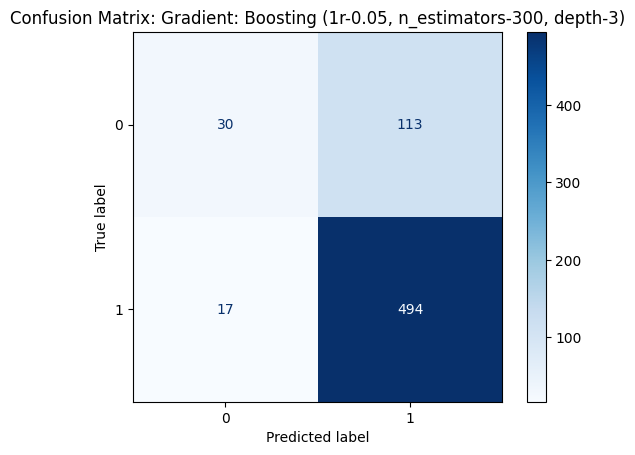

In [ ]:
# Compute confusion natrix
cm = confusion_matrix(y_test, test_pred, labels=pipeline.named_steps['model'].classes_)
#Display contusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipeline.named_steps['model'].classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix: Gradient: Boosting (1r-0.05, n_estimators-300, depth-3)")
plt.show()

Key Findings

•    Data imbalance: Defaults (78.1%) vs Non-defaults (21.9%) → 3.56:1 ratio.
•    Accuracy is misleading (78%) because a model predicting all “default” would still look good.
Model Performance

•    Logistic Regression: Stable, high recall (0.98) on defaults → catches almost all defaulters, but misses many non-defaulters. AUC = 0.68 (moderate separation).
•    Decision Tree: Overfits badly (train 98%, test 69%). Lowest recall (0.77) on defaults, poor AUC (0.58). Weakest model.
•    Random Forest: Better than a single tree, recall 0.90 and precision 0.82, but still overfits (train 98% vs test 76%). AUC = 0.65.
•    Gradient Boosting / CatBoost: Best overall → recall ~0.95, precision ~0.81, F1 ≈ 0.88, AUC ≈ 0.70. Balanced, less overfitting.
•    XGBoost: Strong but slightly less stable (train 91%, test 78%), recall 0.93, precision 0.81, AUC = 0.68.
Weakness Across All Models

•    Extremely poor performance on non-default borrowers (minority class).
•    Confusion matrices show only 18–21% of non-defaults correctly identified.
•    Models are biased toward predicting “default.”
Recommendations

1.    Resample Data – use SMOTE or hybrid oversampling/undersampling to balance.
2.    Class Weights – apply in Logistic Regression, Random Forest, XGBoost, CatBoost.
3.    Threshold Tuning – adjust decision threshold to improve non-default recall.
4.    Better Metrics – track balanced accuracy, recall for both classes, PR AUC.
5.    Feature Engineering – ratios like loan-to-income, utilization rate to improve signal.
Summary: Gradient Boosting and CatBoost perform best under imbalance, but all models currently miss most safe borrowers. To make the model useful for real banking decisions, imbalance handling (SMOTE, class weights, threshold tuning) is essential.





In [ ]:
y_train.value_counts()

,count
good_bad_flag,
1,2045
0,570


In [ ]:
# Hyperparameter options
learning_rates = [0.1, 0.05, 0.1, 0.2]
n_estimators = [100, 200, 300]
max_depths = [3, 4, 5]

results = {}
for lr in learning_rates:
  for n in n_estimators:
    for depth in max_depths:
      model = GradientBoostingClassifier(
          learning_rate=lr,
          n_estimators=n,
          max_depth=depth,
          random_state=42
)

pipeline = Pipeline (steps=[
('preprocessor', preprocessor),
 ('model', model)
])
pipeline.fit(X_train, y_train)
test_pred = pipeline.predict(X_test)

if hasattr(pipeline.named_steps['model'], "predict_proba"):
  test_proba = pipeline.predict_proba(X_test)[:, 1]
else:
  test_proba = pipeline.decision_function(X_test)
  test_proba = (test_proba - test_proba.min()) / (test_proba.max () - test_proba.min())

results [f'Ir-(Ir)_n-(n)_depth=(depth]'] = {
'accuracy': accuracy_score(y_test, test_pred),
'precision': precision_score(y_test, test_pred),
'recall': recall_score(y_test, test_pred),
'f1': f1_score(y_test, test_pred),
'roc_auc': roc_auc_score(y_test, test_proba)
}

# Convert to Dataframe
results_df_final = pd.DataFrame(results).T
results_df_final

,accuracy,precision,recall,f1,roc_auc
Ir-(Ir)_n-(n)_depth=(depth],0.74,0.80,0.89,0.84,0.62



Accuracy model got 74% of the predictions right overall.

Precision model is positive, it was correct 80% of the time.

Recall model caught 89% of the actual positive cases.

F1 model was good balance between precision and recall because it had 84%.

ROC AUC	model was not very good at distinguishing between classes.

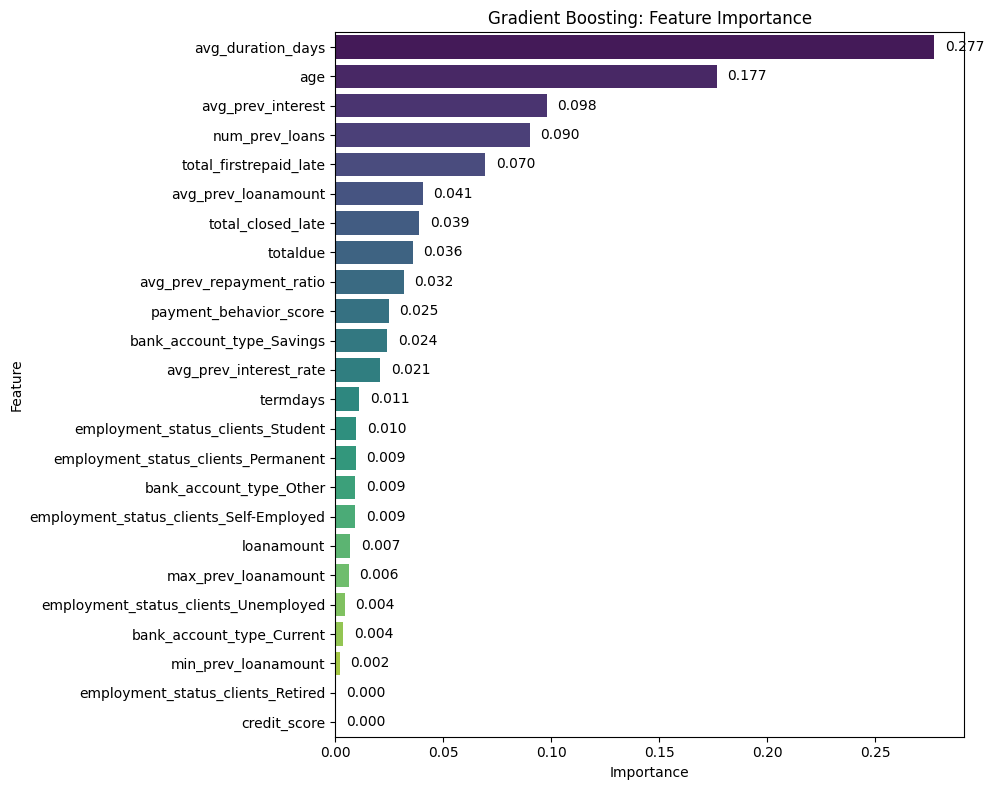

In [ ]:
# Get transformed feature names
preprocessor = pipeline.named_steps['preprocessor']
feature_names = []
for name, transformer, original_columns in preprocessor.transformers_:
    if hasattr(transformer, 'get_feature_names_out'):
        # Handle pipelines that have get_feature_names_out (like OneHotEncoder)
        if isinstance(transformer, Pipeline):
            # Get feature names from the final step of the pipeline
             feature_names.extend(transformer.steps[-1][1].get_feature_names_out(original_columns))
        else:
            feature_names.extend(transformer.get_feature_names_out(original_columns))
    else:
        # Handle transformers without get_feature_names_out (like StandardScaler)
        feature_names.extend(original_columns)


# Create Series of feature importances
feature_importances = pd.Series(
    pipeline.named_steps['model'].feature_importances_,
    index=feature_names
).sort_values(ascending=False)

# Plotting all features
plt.figure(figsize=(10, 8))
sns. barplot(x=feature_importances.values, y=feature_importances.index, palette="viridis")
plt.xlabel ("Importance")
plt. ylabel("Feature")
plt.title("Gradient Boosting: Feature Importance")


# Add values on bars
for i, v in enumerate (feature_importances.values):
  plt.text(v + 0.005, i, f"{v:.3f}", va='center')
plt.tight_layout()
plt.show()

this bar chart shows the importance of different features in predicting the target variable using a Gradient Boosting model.

avg_duration_days is the most important feature by far, meaning the average duration of previous loans plays a major role in the prediction.

age, avg_prev_interest, and num_prev_loans also have strong influence, suggesting borrower history and age are key factors.

Features like credit_score and employment_status_clients_Retired had little to no impact in this model.

Some categorical features (e.g., employment status, bank account type) matter, but less than most numerical ones.

In short, the model relies most heavily on loan duration, borrower age, and past loan behavior to make predictions.